In [421]:
import cv2
def rotate(im, angle, center=None):
    """
    rotate an image `angle` degrees counterclockwise about `center`
    :param im (h, w, c) array
    :param angle (float) angle in degrees
    :param center (optional) point in image coordinates to rotate about
    """
    h, w = im.shape[:2]
    if center is None:
        center = (w // 2, h // 2)
    mat = cv2.getRotationMatrix2D(center=center, angle=angle, scale=1)
    print (mat)
    return cv2.warpAffine(im, mat, (w, h))

def translate_no_pad(im, translation):
    """
    translate an image `tx` to the right, `ty` down
    :param image (h, w, c) array
    :param tx (float) pixels to translate right
    :param ty (float) pixels to translate down
    """
    ty, tx = translation
    h, w = im.shape[:2]
    mat = translation_matrix = np.array([
        [1, 0, tx],
        [0, 1, ty]
    ], dtype=np.float32)
    return cv2.warpAffine(im, mat, (w, h))

In [971]:
import matplotlib.pyplot as plt
import numpy as np
import os

img_dir = 'data/'
out_dir = 'out_path/'

def read_img(img_name):
    img = plt.imread(img_dir + img_name)
    img = img / 255
    if '.tif' in img_name:
        img /= 255
    return img

# translates the image with a circular shift, where translation = (dh, dw)
def translate_circ(img, translation):
    return np.roll(np.roll(img, translation[0], axis=0), translation[1], axis=1)

def split_into_channels(img):
    # compute the height of each part (just 1/3 of total)
    height = np.floor(img.shape[0] / 3.0).astype(np.int_)

    # separate color channels
    b, g, r = img[:height], img[height: 2*height], img[2*height: 3*height]
    return r, g, b

# computes ssd score between two images
def ssd(img1, img2):
    ssd_score = sum((img1 - img2)**2)
    return ssd_score

# computes the normalized cross correlation, by first demeaning and normalizing
def ncc(img_1, img_2):
    n1 = img_1-np.mean(img_1)
    n2 = img_2-np.mean(img_2)
    n1 = n1 / np.sqrt(np.sum(n1**2))
    n2 = n2 / np.sqrt(np.sum(n2**2))
    return -np.sum(img_1*img_2)
    
# brute force algorithm which searches in the [min_tr, max_tr) space for the translation
# and calculates the similarity score based on a metric
def naive_align_two_channels(c1, c2, metric, min_tr_h=-15, max_tr_h=15, min_tr_w=-15, max_tr_w=15):
    min_score = float('inf')
    translation = 0, 0
    for u in range(min_tr_h, max_tr_h):
        for v in range(min_tr_w, max_tr_w):
            test_trans = (u,v)
            c1_trans = translate(c1, test_trans)
            s = metric(c1_trans, c2)
            if s < min_score:
                translation = test_trans
                min_score = s
    return translation, min_score

# stacks the channels to get an RGB image
def stack_channels(r, g, b):
    img_out = np.dstack([r, g, b])
    return img_out

# aligns images by a hard-coded translation
def process_hard_coded(r, g, b, trans_r, trans_g):
    r = translate(r, trans_r)
    g = translate(g, trans_g)
    img_aligned = stack_channels(r, g, b)
    return img_aligned

# naively crops the image by ratio percentage from the left/right sides
def crop_border(img, ratio = 0.2):
    h, w = img.shape[:2]
    return img[int(h*(ratio/2)):int(h*(1-ratio/2)), int(w*(ratio/2)):int(w*(1-ratio/2))]
    
def process_single_scale(img, metric = None, crop = False, translate = translate_circ):
    r, g, b = split_into_channels(img)
    trans_r, trans_g = (0,0), (0,0)
    if metric:
        r_cr, g_cr, b_cr = r, g, b
        if crop:
            r_cr, g_cr, b_cr = map(crop_border, (r, g, b))
        trans_r, _ = naive_align_two_channels(r_cr, b_cr, metric)
        trans_g, _ = naive_align_two_channels(g_cr, b_cr, metric)

        r = translate(r, trans_r)
        g = translate(g, trans_g)
    img_aligned = stack_channels(r, g, b)
    return img_aligned, trans_r, trans_g

def save_img(fname, img_out, out_dir = 'out_path/'):
    img_out = (img_out*255).astype(np.uint8)
    plt.imsave(out_dir + fname, img_out)

In [978]:
### Multiscale Pyramid Algorithm
import skimage
import math

min_size, max_size = 400, 1000
h, w = 3000, 3025

#Computes the alignment needed to align the channels, searching in the space
# [-refine, refine] of displacements from the previous level's optimal displacements after upscaling
def compute_pyramid_alignment(r, g, b, metric, refine=2):
    min_size, max_size = 100, 4000
    resize_ratio = 2
    h, w = r.shape[:2]

    num_times_downscale = max(math.floor(math.log2(h/min_size)), math.floor(math.log2(w/min_size)))
    scale_factor = pow(1/resize_ratio, num_times_downscale)
    
    num_pyramid_search = 0
    start_search_space = (-20, 20)
    min_r_score, min_g_score = float('inf'), float('inf')
    best_trans_r, best_trans_g = (0,0), (0,0)
    
    min_tr_r_h, max_tr_r_h = (0,0)
    min_tr_r_w, max_tr_r_w = (0,0)
    
    min_tr_g_h, max_tr_g_h = (0,0)
    min_tr_g_w, max_tr_g_w = (0,0)

    while scale_factor * h < max_size and scale_factor * w < max_size and num_times_downscale - num_pyramid_search >= 0:
        num_pyramid_search += 1
        r_rs = skimage.transform.rescale(r, scale_factor)
        g_rs = skimage.transform.rescale(g, scale_factor)
        b_rs = skimage.transform.rescale(b, scale_factor)

        min_tr_r_h, max_tr_r_h = start_search_space if num_pyramid_search == 1 else (best_trans_r[0]-refine, best_trans_r[0]+refine+1)
        min_tr_r_w, max_tr_r_w = start_search_space if num_pyramid_search == 1 else (best_trans_r[1]-refine, best_trans_r[1]+refine+1)
        min_tr_g_h, max_tr_g_h = start_search_space if num_pyramid_search == 1 else (best_trans_g[0]-refine, best_trans_g[0]+refine+1)
        min_tr_g_w, max_tr_g_w = start_search_space if num_pyramid_search == 1 else (best_trans_g[1]-refine, best_trans_g[1]+refine+1)
                
        best_trans_r, min_r_score = naive_align_two_channels(r_rs, b_rs, metric, min_tr_r_h, max_tr_r_h, min_tr_r_w, max_tr_r_w)
        best_trans_g, min_g_score = naive_align_two_channels(g_rs, b_rs, metric, min_tr_g_h, max_tr_g_h, min_tr_g_w, max_tr_g_w)

        scale_factor *= resize_ratio
        if num_times_downscale - num_pyramid_search >= 0:
            best_trans_r = best_trans_r[0] * 2, best_trans_r[1] * 2
            best_trans_g = best_trans_g[0] * 2, best_trans_g[1] * 2
    
    while num_times_downscale - num_pyramid_search > 0:
        num_pyramid_search += 1
        best_trans_r = best_trans_r[0] * 2, best_trans_r[1] * 2
        best_trans_g = best_trans_g[0] * 2, best_trans_g[1] * 2
        
    return best_trans_r, best_trans_g
      
# Computes the translations needed to align the image and returns an aligned and processed image
def process_pyramid_scale(img, conv_filter = True, refine = 2, metric = ssd, precrop = True, postcrop = True, translate = translate_circ):
    r, g, b = split_into_channels(img)
    trans_r, trans_g = (0,0), (0,0)
    if metric:
        r_pr, g_pr, b_pr = r, g, b
        if precrop:
            r_pr, g_pr, b_pr = map(crop_border, (r, g, b))
        if conv_filter:
           r_pr, g_pr, b_pr = map(skimage.filters.sobel, (r_pr, g_pr, b_pr))
        trans_r, trans_g = compute_pyramid_alignment(r_pr, g_pr, b_pr, ssd, refine)
        r = translate(r, trans_r)
        g = translate(g, trans_g)
    img_aligned = stack_channels(r, g, b)
    img_aligned = np.clip(img_aligned, 0, 1)
    if postcrop:
        img_aligned = crop_border(img_aligned)
    return img_aligned, trans_r, trans_g

def align_image_pyramid_scale(img_name, save_img=False, conv_filter=True, refine=2, metric=ssd, precrop=True, postcrop=True, translate=translate_circ):
    name, extension = img_name.split('.')
    img = read_img(img_name)
    img_aligned, trans_r, trans_g = process_pyramid_scale(img, conv_filter, refine, metric, precrop, postcrop, translate)
    if save_img:
        save_img(name + 'jpg', img_aligned, out_dir='out/')
    return img_aligned, trans_r, trans_g


0.5732234331269865
0.019087813654653788
0.018899306486762288


Text(0.5, 1.0, 'b')

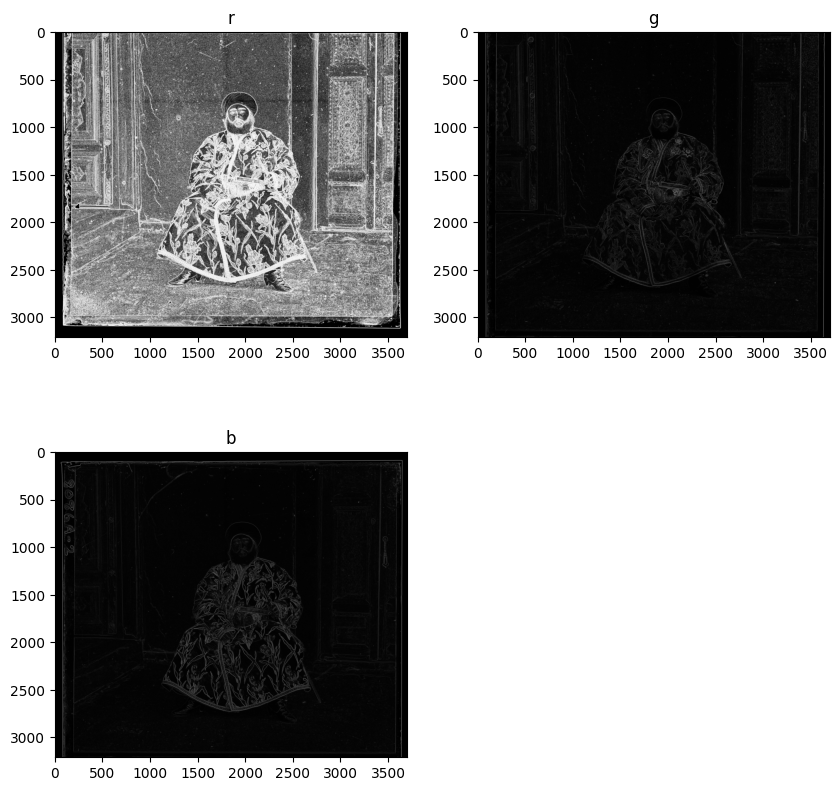

In [928]:
rows, columns = 2, 2
fig = plt.figure(figsize=(10, 10))
fig.add_subplot(rows, columns, 1)
max_b = np.max(r_cr)
print(max_b)
plt.imshow( skimage.exposure.equalize_hist(r_cr), cmap='gray')
plt.title('r')
fig.add_subplot(rows, columns, 2)
plt.imshow(g_cr/np.max(g_cr), cmap='gray')
print(np.mean(g_cr))

plt.title('g')        
fig.add_subplot(rows, columns, 3)
plt.imshow(b_cr/np.max(b_cr), cmap='gray')
print(np.mean(b_cr))
plt.title('b')

In [926]:
img_name = 'emir.tif'
name, extension = img_name.split('.')
translate = translate_circ
img = read_img(img_name)
r, g, b = split_into_channels(img)
r_cr, g_cr, b_cr = map(skimage.filters.sobel, (r, g, b))
b_r, b_g, b_b = map(np.max, (r_cr, g_cr, b_cr))
print(b_r, b_g, b_b)
print(np.max(r_cr))

0.5732234331269865 0.5802224138035159 0.5703879744781692
0.5732234331269865


In [963]:
img_name = 'church.tif'
name, extension = img_name.split('.')
translate = translate_circ
img = read_img(img_name)
img_aligned, trans_r, trans_g = process_pyramid_scale(img, conv_filter=True, refine=2, metric=ssd, precrop=True)
print(trans_r, trans_g)
img_aligned = np.clip(img_aligned, 0, 1)

(58, -4) (25, 4)


In [ ]:
img_cropped = crop_border(img_aligned)
plt.imshow(img_cropped)

In [1020]:
### Functions to visualize different contrast manipulations. 
# The histogram plotting code is taken from https://scikit-image.org/docs/stable/auto_examples/color_exposure/plot_equalize.html.
def plot_img_and_hist(image, axes, bins=256):
    """Plot an image along with its histogram and cumulative histogram.

    """
    ax_img, ax_hist = axes
    ax_cdf = ax_hist.twinx()

    # Display image
    ax_img.imshow(image, cmap=plt.cm.gray)
    ax_img.set_axis_off()

    # Display histogram
    ax_hist.hist(image.ravel(), bins=bins, histtype='step', color='black')
    ax_hist.ticklabel_format(axis='y', style='scientific', scilimits=(0, 0))
    ax_hist.set_xlabel('Pixel intensity')
    ax_hist.set_xlim(0, 1)
    ax_hist.set_yticks([])

    # Display cumulative distribution
    img_cdf, bins = skimage.exposure.cumulative_distribution(image, bins)
    ax_cdf.plot(bins, img_cdf, 'r')
    ax_cdf.set_yticks([])

    return ax_img, ax_hist, ax_cdf

# Plots the effect of histogram equalization, rescaling, and adaptive histogram equalization, along with the histograms and cdf.
def plot_contrast_changes_with_histograms(img):
    fig = plt.figure(figsize=(16, 10))
    axes = np.zeros((2, 4), dtype=object)
    axes[0, 0] = fig.add_subplot(2, 4, 1)
    for i in range(1, 4):
        axes[0, i] = fig.add_subplot(2, 4, 1+i, sharex=axes[0,0], sharey=axes[0,0])
    for i in range(0, 4):
        axes[1, i] = fig.add_subplot(2, 4, 5+i)
    
    img_equalized = skimage.exposure.equalize_hist(img)
    img_rescale = skimage.exposure.rescale_intensity(img, in_range='image', out_range=(0,1))
    img_adapteq = skimage.exposure.equalize_adapthist(img)
    
    ax_img, ax_hist, ax_cdf = plot_img_and_hist(img, axes[:, 0])
    ax_img.set_title('Default')
    
    ax_img, ax_hist, ax_cdf = plot_img_and_hist(img_rescale, axes[:, 1])
    ax_img.set_title('Rescaling')
    ax_img, ax_hist, ax_cdf = plot_img_and_hist(img_equalized, axes[:, 2])
    ax_img.set_title('Histogram equalization')
    ax_img, ax_hist, ax_cdf = plot_img_and_hist(img_adapteq, axes[:, 3])
    ax_img.set_title('Adaptive equalization')

# Plots the effect of various contrast manipulations without histograms
def plot_contrast_changes_simple(img):
    img_equalized =  skimage.exposure.equalize_hist(img)
    img_rescale = skimage.exposure.rescale_intensity(img, in_range='image', out_range=(0,1))
    img_adapteq = skimage.exposure.equalize_adapthist(img, clip_limit=0.008)
    
    rows, columns = 2, 2
    fig = plt.figure(figsize=(8, 8))
    fig.add_subplot(rows, columns, 1)
    plt.imshow(img)
    plt.title('Normal')

    fig.add_subplot(rows, columns, 2)
    plt.imshow(img_equalized)
    plt.title('img_equalized')

    fig.add_subplot(rows, columns, 3)
    plt.imshow(img_rescale)
    plt.title('img_rescale')

    fig.add_subplot(rows, columns, 4)
    plt.imshow(img_adapteq)
    plt.title('img_adapteq')

(90, 23) (42, 17)


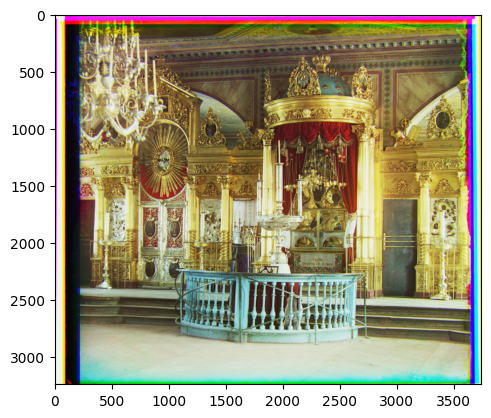

In [909]:
img_name = 'icon.tif'
name, extension = img_name.split('.')
translate = translate_circ
img = read_img(img_name)
img_aligned, trans_r, trans_g = process_pyramid_scale(img, conv_filter=True, refine=2, metric=ssd, precrop=True)
print(trans_r, trans_g)
img_aligned = np.clip(img_aligned, 0, 1)
plt.imshow(img_aligned)

In [887]:
img_name = 'emir.tif'
name, extension = img_name.split('.')
translate = translate_circ
img = read_img(img_name)
img_aligned, trans_r, trans_g = process_pyramid_scale(img, refine=2, metric=ssd, crop=True)
print(trans_r, trans_g)

(93, -305) (49, 24)


In [907]:
out_file = 'translations_2_ssd_sobel.txt'
out_dir = 'out/pyramid/'
f = open(out_dir + out_file, "a")
for img_name in os.listdir('data'):
    name, extension = img_name.split('.')
    translate = translate_circ
    img = read_img(img_name)
    img_aligned, trans_r, trans_g = process_pyramid_scale(img, conv_filter=True, refine=2, metric=ssd, precrop=True)
    img_aligned = np.clip(img_aligned, 0, 1)
    # plt.imshow(img_aligned)
    print(img_name, trans_r, trans_g)
    mess = 'Image {0}: ({1}, {2}), ({3}, {4})\n'.format(img_name, trans_r[0], trans_r[1], trans_g[0], trans_g[1])
    f.write(mess)
    plt.imsave(out_dir + name + '.jpg', img_aligned)
    
f.close()

emir.tif (107, 40) (49, 24)
monastery.jpg (3, 2) (-3, 2)
church.tif (58, -4) (25, 4)
three_generations.tif (111, 9) (54, 12)
melons.tif (177, 13) (80, 10)
onion_church.tif (107, 35) (52, 25)
train.tif (85, 29) (41, 2)
tobolsk.jpg (6, 3) (3, 3)
icon.tif (90, 23) (42, 17)
cathedral.jpg (12, 3) (5, 2)
self_portrait.tif (176, 37) (78, 29)
harvesters.tif (124, 14) (60, 17)
sculpture.tif (139, -26) (33, -11)
lady.tif (120, 13) (56, 9)


(12, 3) (5, 2)


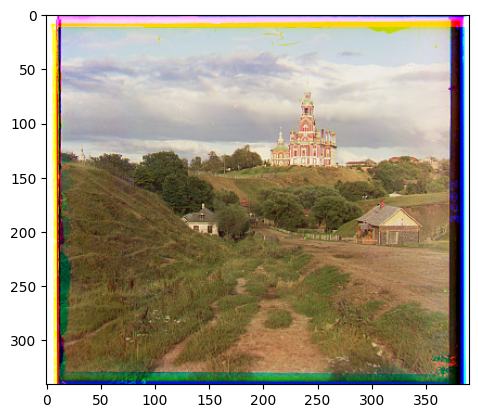

In [737]:
translate = translate_circ
img_name = 'cathedral.jpg'
img = read_img(img_name)
r, g, b = split_into_channels(img)
r_cr, g_cr, b_cr = map(crop_border, (r, g, b))

img_aligned, trans_r, trans_g = process_single_scale(img, ssd, crop=True)
plt.imshow(img_aligned)
print(trans_r, trans_g)

In [676]:
img_name = 'emir.tif'
img = read_img(img_name)

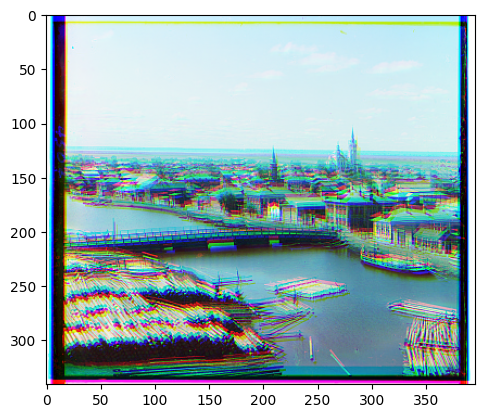

In [571]:
img_def, _, _ = process(img)
plt.imshow(img_def)

In [721]:
img_name = 'cathedral.jpg'
img = read_img(img_name)

(7, -1) (7, -1) (341, 390, 3)


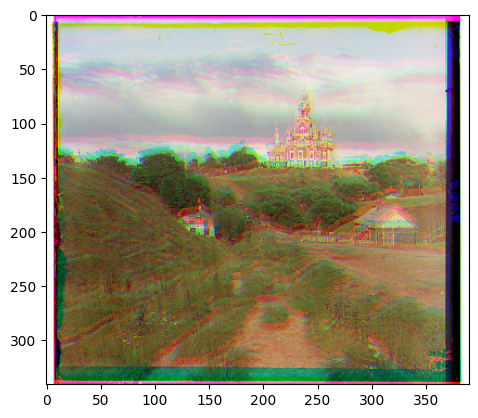

In [722]:
translate = translate_circ
img_aligned, trans_r, trans_g = process_single_scale(img, metric=ssd, crop=True)
plt.imshow(img_aligned)
print(trans_r, trans_g,img_aligned.shape)

In [691]:
out_dir = 'out/ncc'
for img_name in os.listdir('data'):
    if '.jpg' in img_name:
        img = read_img(img_name)
        print(img_name)
        translate = translate_circ
        img_aligned, trans_r, trans_g = process_single_scale(img, metric=ssd, crop=True)
        post_cr = crop_border(img_aligned, 0.1)
        # plt.imshow(img_aligned)
        print(trans_r, trans_g, img_aligned.shape)
        # plt.imsave(out_dir + img_name, img_aligned)


monastery.jpg
(3, 2) (-3, 2) (341, 391, 3)
tobolsk.jpg
(6, 3) (3, 3) (341, 396, 3)
cathedral.jpg
(12, 3) (5, 2) (341, 390, 3)


(6, 3) (3, 2) (306, 357, 3)


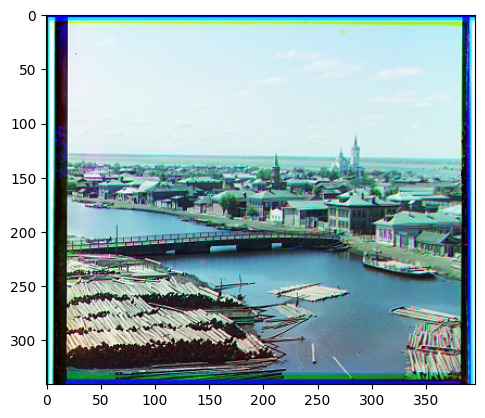

In [585]:
#use_pre_crop False, post_crop
translate = translate_no_pad
img_aligned, trans_r, trans_g = process(img, align_func=naive_align_two_channels, metric=ssd, crop=True)
post_cr = crop_border(img_aligned, 0.1)
plt.imshow(img_aligned)
print(trans_r, trans_g, post_cr.shape)

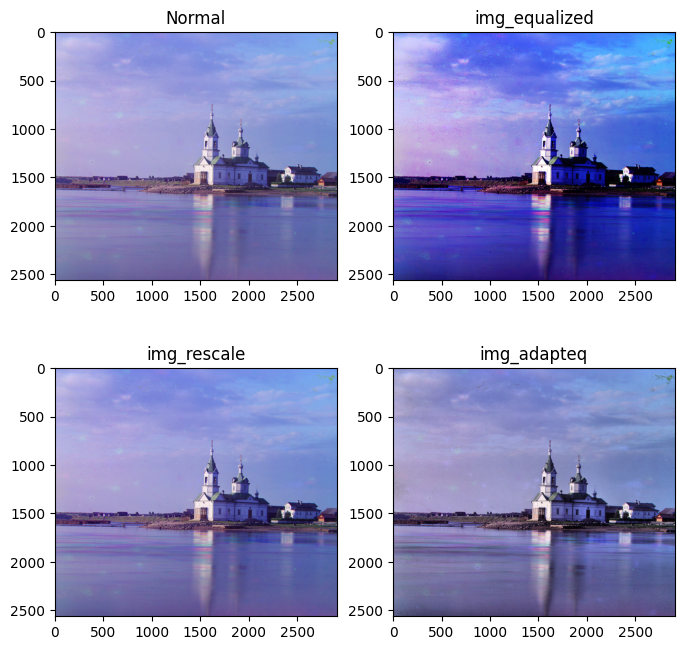

In [1001]:
img_name = 'church.tif'
img_church, _, _ = align_image_pyramid_scale(img_name)
plot_contrast_changes_simple(img_church)

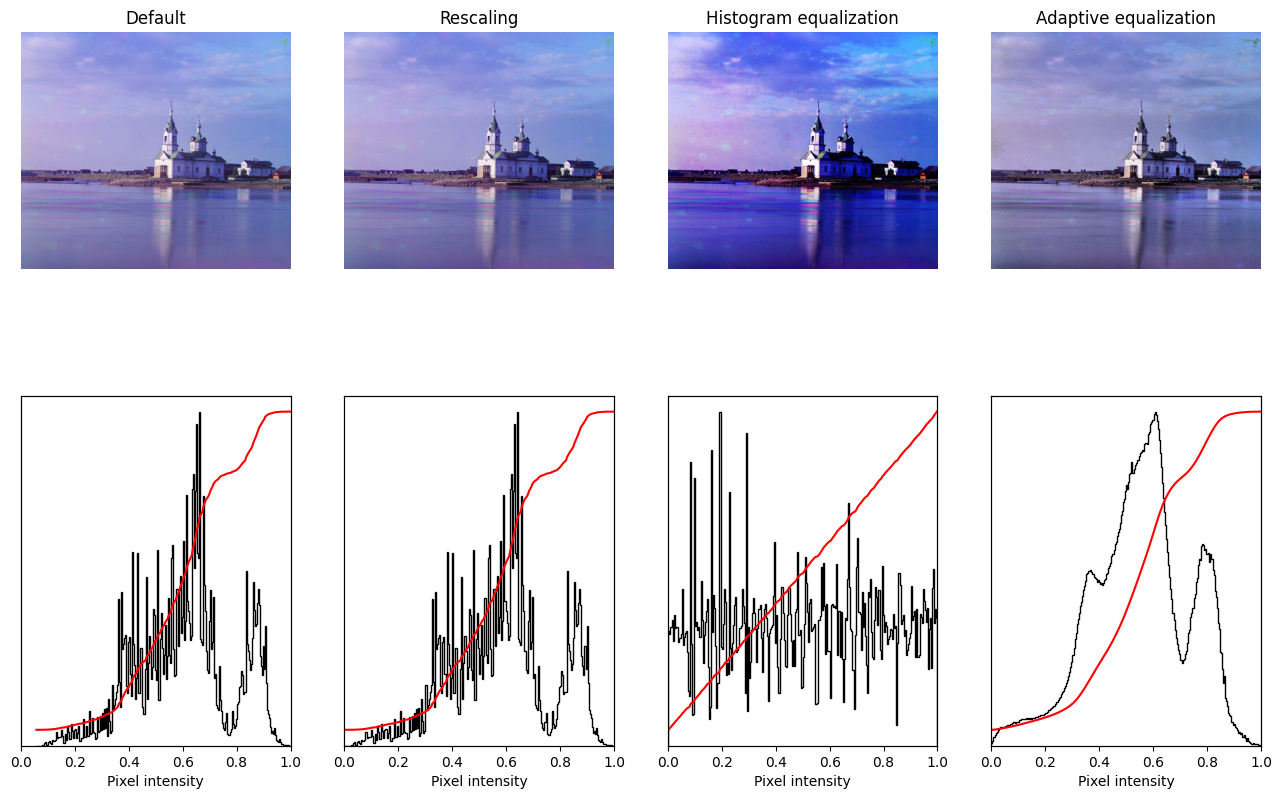

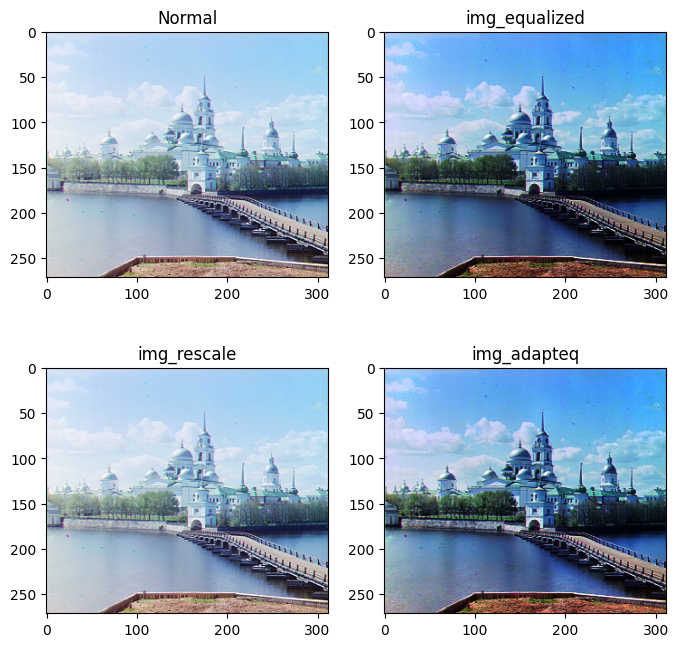

In [1024]:
img_name = 'monastery.jpg'
img_monastery, _, _ = align_image_pyramid_scale(img_name)
plot_contrast_changes_simple(img_monastery)

/opt/homebrew/lib/python3.10/site-packages/skimage/_shared/utils.py:394: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel, or set channel_axis.
  return func(*args, **kwargs)


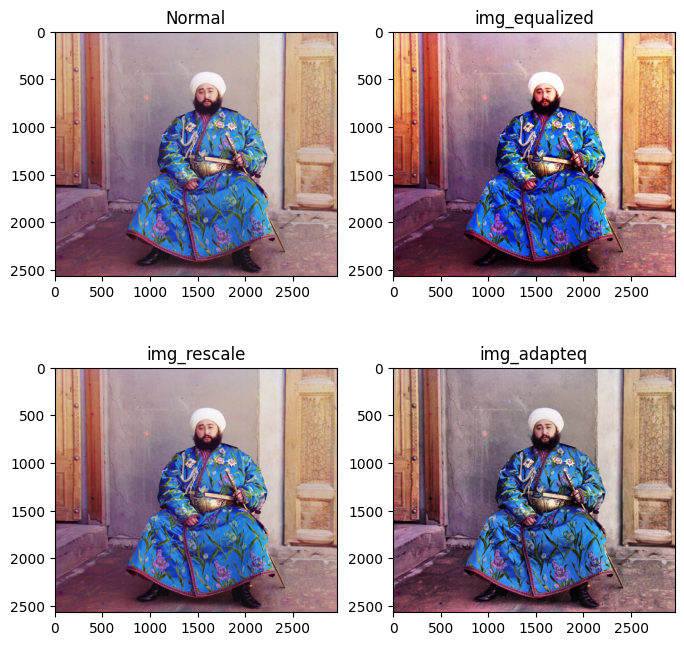

In [1017]:
img_name = 'emir.tif'
img_monastery, _, _ = align_image_pyramid_scale(img_name)
plot_contrast_changes_simple(img_monastery)

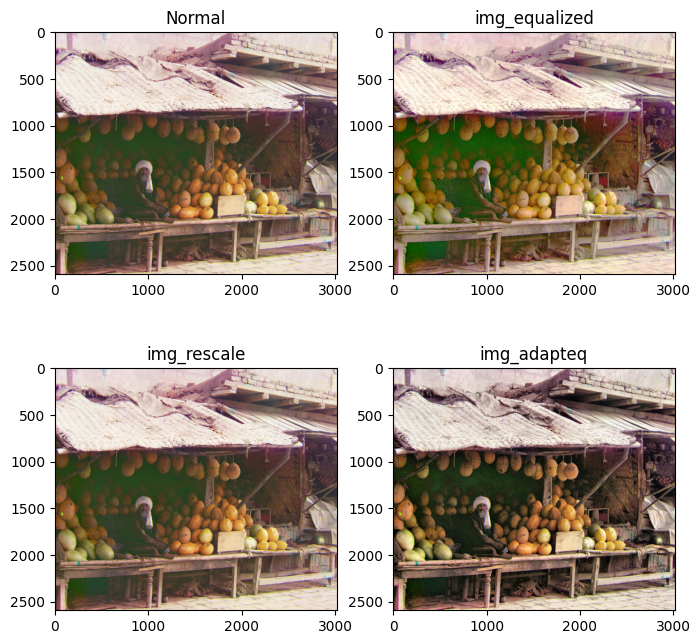

In [1014]:
img_name = 'melons.tif'
img_monastery, _, _ = align_image_pyramid_scale(img_name)
plot_contrast_changes_simple(img_monastery)

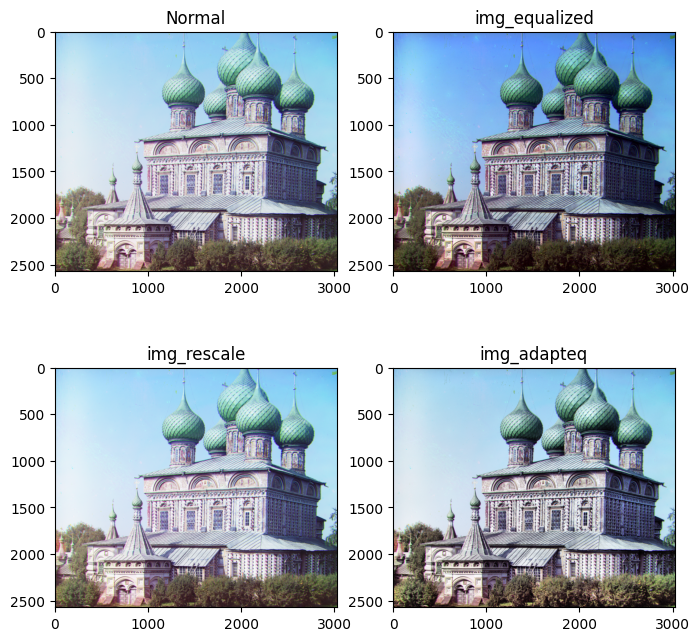

In [1013]:
img_name = 'onion_church.tif'
img_monastery, _, _ = align_image_pyramid_scale(img_name)
plot_contrast_changes_simple(img_monastery)

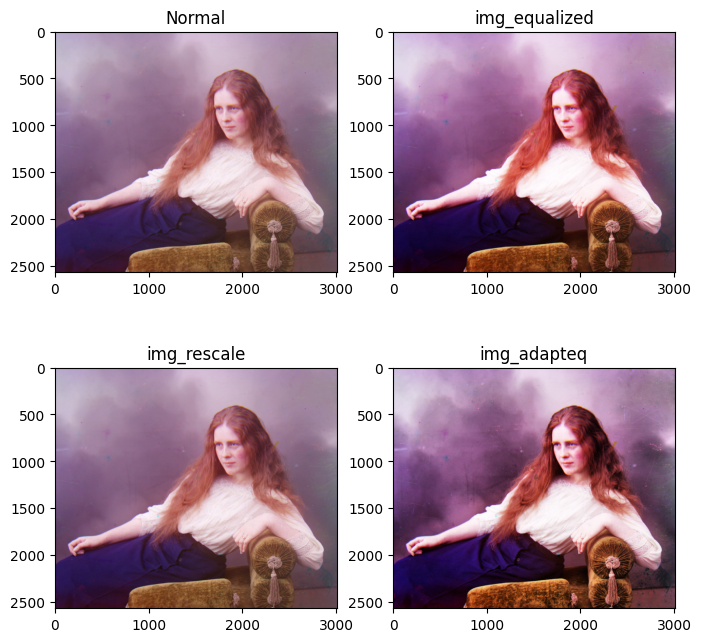

In [1023]:
img_name = 'lady.tif'
img_monastery, _, _ = align_image_pyramid_scale(img_name)
plot_contrast_changes_simple(img_monastery)

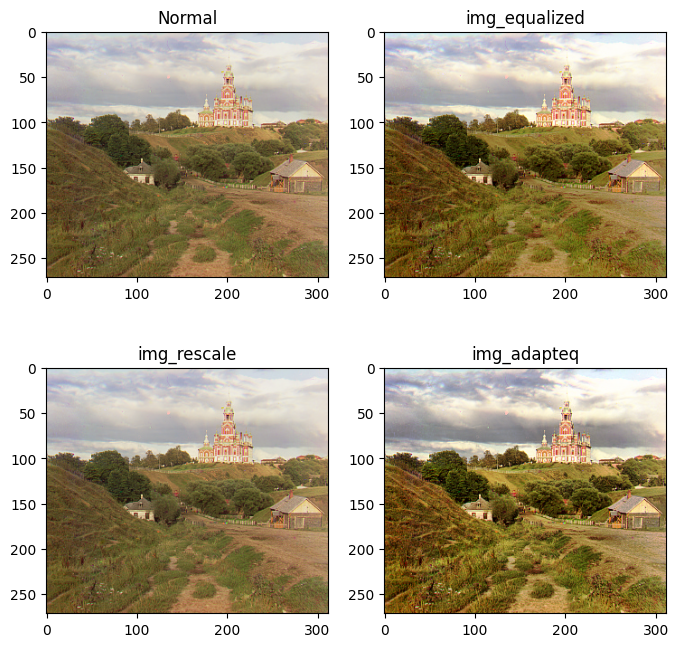

In [1022]:
img_name = 'cathedral.jpg'
img_monastery, _, _ = align_image_pyramid_scale(img_name)
plot_contrast_changes_simple(img_monastery)

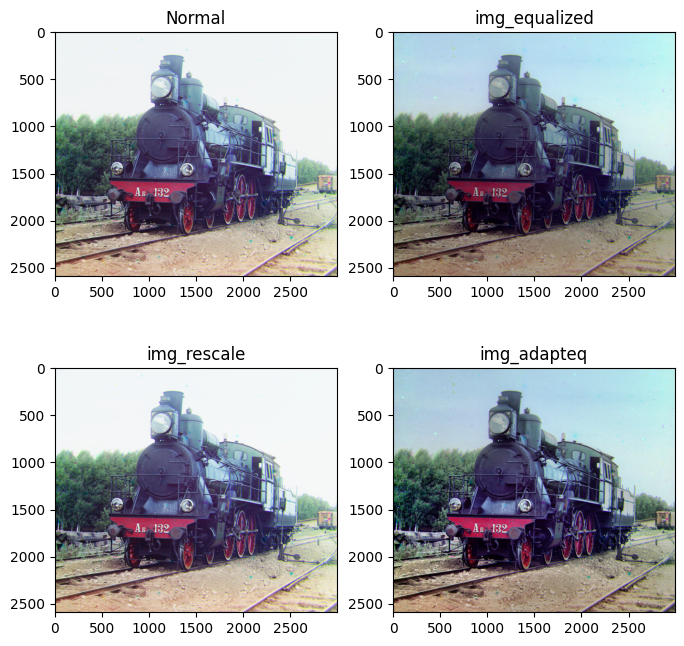

In [1021]:
img_name = 'train.tif'
img_monastery, _, _ = align_image_pyramid_scale(img_name)
plot_contrast_changes_simple(img_monastery)